<center>
  <b><font size=6.5 face="Times">
    HierbaNetV1
  </font></b><br/>
  <font size=4 face="brush script"><i>
    Implementation Of HierbaNetV1 - A Novel Convolutional Neural Network Architecture
  </i></font>
</center>

<font face="cursive">
  <h6>Related references:</h6>
  <a href="https://github.com/JustinaMichael/HierbaNetV1-A-Novel-CNN-Architecture.git">GitHub repository for source code</a> <br/>
  <a href="https://github.com/JustinaMichael/SorghumWeedDataset_Classification.git">GitHub repository for dataset</a> <br/>
  <a href="https://data.mendeley.com/datasets/4gkcyxjyss/1">Mendeley data repository for dataset(First appeared) </a>
</font>

<font face="monospace">
  <h6>Contributors profile:</h6>
  <a href="https://scholar.google.com/citations?user=pEEzO14AAAAJ&hl=en&oi=ao">Justina Michael. J<a/>
  <a href="https://scholar.google.com/citations?user=Es49w08AAAAJ&hl=en&oi=ao">Dr. M. Thenmozhi<a/>
</font>

### Cloning the 'SorghumWeedDataset_Classification' dataset from GitHub repository

In [1]:
!git clone https://github.com/JustinaMichael/SorghumWeedDataset_Classification.git

Cloning into 'SorghumWeedDataset_Classification'...
remote: Enumerating objects: 4339, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 4339 (delta 4), reused 5 (delta 0), pack-reused 4326
Receiving objects: 100% (4339/4339), 63.63 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (4/4), done.


### Cloning the HierbaNetV1 trained weights from GitHub repository

In [2]:
!git clone https://github.com/JustinaMichael/HierbaNetV1-A-Novel-CNN-Architecture.git

Cloning into 'HierbaNetV1-A-Novel-CNN-Architecture'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 8), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (22/22), 11.25 KiB | 11.25 MiB/s, done.
Resolving deltas: 100% (8/8), done.


### Importing necessary libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.models import Model, Sequential, load_model
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from numpy import expand_dims
import random
import warnings
import os
import shutil
from PIL import ImageFile
from PIL import Image
import itertools
from scipy import interp
from itertools import cycle
import time
import numpy as np
import seaborn as sns
import pandas as pd
from glob import glob


### Declaring necessary variables

In [4]:
# Declaring train, validation and test paths
root_path = '/content/SorghumWeedDataset_Classification'
datasetFolderName=root_path
sourceFiles=[]
classLabels=['Class0_Sorghum','Class1_Grass','Class2_BroadLeafWeed']
X=[]
Y=[]
train_path=datasetFolderName+'/Train/'
validation_path=datasetFolderName+'/Validate/'
test_path=datasetFolderName+'/Test/'

# random seed setting
tf.random.set_seed(0)

#Finding the total number of test images
len_test_set = 0
for root, dirs, files in (os.walk(test_path)):
    for name in (files):
        len_test_set = len_test_set + 1

#Finding total number of classes
folders = glob(train_path + '/*')
num_classes = len(folders)

#Declaring the number of epochs
epochs = 50

#Declaring the number of folds
num_folds = 10

#Image resize
IMAGE_SIZE = [224, 224]

#Decalring batch size
batch_size = 32

# Class mode for data augmentation (binary or categorical)
class_mode = 'categorical'

#Declaring learning rate
my_learning_rate = .001

# Declaring the class index in a list
classes=[0,1,2]

# Declaring class names for classification report
target_names = ['class 0', 'class 1', 'class 2']

# Assigining individual TEST class count for ROC
class_count = [140,147,144]

# Location to store the model architecture and weights
model_checkpoint = root_path + '/bestmodel.h5'

#Train data
categories=os.listdir(train_path)
labels=[i for i in range(len(categories))]
label_dict=dict(zip(categories,labels))

#Validation data
categories2=os.listdir(validation_path)
labels2=[i for i in range(len(categories2))]
label_dict2=dict(zip(categories2,labels2))

#Test data
categories3=os.listdir(test_path)
labels3=[i for i in range(len(categories3))]
label_dict3=dict(zip(categories3,labels3))

### Procedure for Stratified k-fold cross validation

In [5]:
# Transferring images between folders for cross validation
def transferBetweenFolders(source, dest, splitRate):
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/',
                               datasetFolderName+'/'+dest+'/'+label+'/',
                               splitRate)
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/Train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
            if(folderName==classLabels[i]):
                Y.append(i)

# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
    prepareNameWithLabels(classLabels[i])
X=np.asarray(X)
Y=np.asarray(Y)

### HierbaNetV1 customized architecture

In [6]:
# Defining the convolution, batch normalization and activation function
def conv_Bn_Act(output, filters, kernel_row, kernel_col, block, count):
    output = keras.layers.Conv2D(filters=filters, kernel_size=(kernel_row,kernel_col), strides=(1, 1),padding='same',
                              data_format='channels_last', activation=None, kernel_initializer='glorot_uniform',
                              bias_initializer="zeros", name=block+"_Conv"+count)(output)
    output = keras.layers.BatchNormalization(axis=3, momentum=0.99, epsilon=0.001, scale=True, beta_initializer="zeros",
                                             gamma_initializer="ones", name=block+"_BNorm"+count)(output)
    output = keras.layers.LeakyReLU(alpha=0.001, name=block+"_LeakyRelu"+count)(output)

    return output

# Module for extracting high-level features
def featureExtraction_HighLevel(output_high, block):
    kernel_1x1 = conv_Bn_Act(output=output_high, filters=64, kernel_row=1, kernel_col=1, block=block+"_HL", count="1")
    kernel_3x3 = conv_Bn_Act(output=output_high, filters=64, kernel_row=3, kernel_col=3, block=block+"_HL", count="2")
    kernel_5x5 = conv_Bn_Act(output=output_high, filters=64, kernel_row=5, kernel_col=5, block=block+"_HL", count="3")
    kernel_7x7 = conv_Bn_Act(output=output_high, filters=64, kernel_row=7, kernel_col=7, block=block+"_HL", count="4")
    output_high = keras.layers.concatenate([kernel_1x1, kernel_3x3, kernel_5x5, kernel_7x7], axis=3, name=block+"_HL"+"_Concatenate")

    output_high = conv_Bn_Act(output=output_high, filters=256, kernel_row=3, kernel_col=3, block=block+"_HL", count="5")
    output_high = conv_Bn_Act(output=output_high, filters=256, kernel_row=3, kernel_col=3, block=block+"_HL", count="6")
    output_high = conv_Bn_Act(output=output_high, filters=512, kernel_row=3, kernel_col=3, block=block+"_HL", count="7")
    output_high = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name=block+"_HL"+"_MaxPool")(output_high)

    return output_high

# Module for extracting low-level features
def featureExtraction_LowLevel(output_low, block):
    output_low = conv_Bn_Act(output=output_low, filters=64, kernel_row=3, kernel_col=3, block=block+"_LL", count="1")
    output_low = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name=block+"_LL"+"_MaxPool")(output_low)

    return output_low

# Module for integrating high-level features and low-level features
def feature_Integration(output, block):
    highlevel_features = featureExtraction_HighLevel(output, block=block)
    lowlevel_features = featureExtraction_LowLevel(output, block=block)
    output = keras.layers.concatenate([highlevel_features, lowlevel_features], axis=3, name=block+"_Concatenate")

    return output

# Building the model
input_image = keras.Input(shape=(224, 224, 3), name="Input")

#model_Base
model = conv_Bn_Act(output=input_image, filters=32, kernel_row=3, kernel_col=3, block="Base", count="1")
model = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name="Base_MaxPool"+'1')(model)

#block_1
model = feature_Integration(model, block="B1")

#model_Base
model = conv_Bn_Act(output=model, filters=576, kernel_row=3, kernel_col=3, block="Base", count="2")
model = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name="Base_MaxPool"+'2')(model)

#block_2
model = feature_Integration(model, block="B2")

#model_Base
model = conv_Bn_Act(output=model, filters=576, kernel_row=3, kernel_col=3, block="Base", count="3")
model = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name="Base_MaxPool"+'3')(model)

model = keras.layers.GlobalAveragePooling2D(data_format='channels_last', name="Base_GlobalAvgPool")(model)

model = keras.layers.Dropout(rate=0.2, seed=None, name="Base_Dropout")(model)
model = keras.layers.Dense(units=num_classes, activation='softmax',kernel_initializer="glorot_uniform",
                           bias_initializer="zeros", name="Base_Dense")(model)

model =  keras.Model(inputs=input_image, outputs=model, name='HierbaNetV1')

model.summary()

Model: "HierbaNetV1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Base_Conv1 (Conv2D)         (None, 224, 224, 32)         896       ['Input[0][0]']               
                                                                                                  
 Base_BNorm1 (BatchNormaliz  (None, 224, 224, 32)         128       ['Base_Conv1[0][0]']          
 ation)                                                                                           
                                                                                                  
 Base_LeakyRelu1 (LeakyReLU  (None, 224, 224, 32)         0         ['Base_BNorm1[0][0]'

### Model compilation, training, and validation

In [7]:
# Model cost and optimization
model.compile(Adam(learning_rate=my_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Stratified K-Fold Cross validation (Training, Validation, Testing)
# Mark 'Train_Val' as "1" to train and validate the model
# Mark 'Train_Val' as "0" to only test model by loading trained HierbaNetV1 weights
Train_Val = 0

if Train_Val == 1:
  # ===============Stratified K-Fold======================
  skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
  skf.get_n_splits(X, Y)
  foldNum = 0
  predict_result = np.empty([len_test_set, num_classes])
  model_predictions, y_pred, folds_test_loss, folds_test_acc, folds_train_loss, folds_train_accuracy, folds_val_loss, folds_val_accuracy = ([] for i in range(8))
  for train_index, val_index in skf.split(X, Y):
      #First cut all images from validation to train (if any exists)
      transferAllClassBetweenFolders('Validate', 'Train', 1.0)
      foldNum += 1
      print(f"\n----------Results for fold {foldNum}---------------")
      X_train, X_val = X[train_index], X[val_index]
      Y_train, Y_val = Y[train_index], Y[val_index]
      # Move validation images of this fold from train folder to the validation folder
      for eachIndex in range(len(X_val)):
          classLabel=''
          for i in range(len(classLabels)):
            if(Y_val[eachIndex]==i):
                classLabel=classLabels[i]
          #Then, copy the validation images to the validation folder
          shutil.move(datasetFolderName+'/Train/'+classLabel+'/'+X_val[eachIndex],
                      datasetFolderName+'/Validate/'+classLabel+'/'+X_val[eachIndex])

      # Data Augmentation
      train_datagen = ImageDataGenerator(rescale = 1./255,
                                        rotation_range = 45,
                                        width_shift_range = 0.3,
                                        shear_range = 0.25,
                                        zoom_range = 0.25,
                                        height_shift_range = 0.3,
                                        horizontal_flip = True,
                                        brightness_range=(0.2, 0.9),
                                        vertical_flip = True,
                                        fill_mode = 'reflect'
                              )
      validation_datagen = ImageDataGenerator(rescale=1./255)
      test_datagen = ImageDataGenerator(rescale=1./255)

      training_set = train_datagen.flow_from_directory(
          train_path,
          target_size=IMAGE_SIZE,
          batch_size=batch_size,
          class_mode='categorical',
          subset='training')
      valid_set = validation_datagen.flow_from_directory(
          validation_path,
          target_size=IMAGE_SIZE,
          batch_size=batch_size,
          class_mode='categorical',
          shuffle=False)
      test_set = test_datagen.flow_from_directory(
          test_path,
          target_size=IMAGE_SIZE,
          batch_size=batch_size,
          class_mode='categorical',
          shuffle=False)

      # Early stopping and model check point
      es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
      mc = ModelCheckpoint(monitor = "val_accuracy", filepath = model_checkpoint , verbose = 1, save_best_only = True, mode = 'auto')
      cd = [es, mc]

      #Model training - fit model
      history = model.fit(training_set,
                              validation_data=valid_set,
                              epochs=epochs,
                              steps_per_epoch=len(training_set),
                              validation_steps=len(valid_set),
                              callbacks = cd
                            )

      #Finding the maximum validation accuracy and its respective metrics
      max_val_acc = max(history.history['val_accuracy'])
      indices = [index for index, value in enumerate(history.history['val_accuracy']) if value == max_val_acc]
      index_max_val_acc = indices[0]
      max_training_loss = history.history['loss'][index_max_val_acc]
      max_training_accuracy = history.history['accuracy'][index_max_val_acc]
      max_validation_loss = history.history['val_loss'][index_max_val_acc]

      #Printing all metrics
      print("Training Loss: ", max_training_loss)
      print("Training Accuracy: ", max_training_accuracy)
      print("Validation Loss: ", max_validation_loss)
      print("Validation Accuracy: ", max_val_acc)

      #Sum of all metrics
      folds_train_loss.append(max_training_loss)
      folds_train_accuracy.append(max_training_accuracy)
      folds_val_loss.append(max_validation_loss)
      folds_val_accuracy.append(max_val_acc)

      #Train loss VS Validation loss graph
      plt.plot(history.history['loss'], 'g', label='Training loss')
      plt.plot(history.history['val_loss'], 'b', label='Validation loss')
      plt.title('Model Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epochs')
      plt.legend(loc='upper right')
      plt.grid(color='black', linestyle='-', linewidth=0.5)
      plt.show()
      plt.savefig("/results/Trainloss_Valloss.png")
      plt.clf()

      #Train accuracy vs validation accuracy
      plt.plot(history.history['accuracy'], 'g', label='Training accuracy')
      plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
      plt.title('Model Accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epochs')
      plt.legend(loc='lower right')
      plt.grid(color='black', linestyle='-', linewidth=0.5)
      plt.show()
      plt.savefig("/results/TrainAcc_ValiAcc.png")
      plt.clf()

  # CALCULATING MEAN FOR ALL FOLD METRIC (ACCURACY and LOSS)
  print("\n--------- Mean accuracies - Train and Validation, Loss and Accuracy----------")
  print("Mean training loss of model is ", np.mean(folds_train_loss, axis=0))
  print("Mean training accuracy of model is ", np.mean(folds_train_accuracy, axis=0))
  print("Mean validation loss of model is ", np.mean(folds_val_loss, axis=0))
  print("Mean validation accuracy of model is ", np.mean(folds_val_accuracy, axis=0))
  # Loading the model
  model = load_model(model_checkpoint)

elif Train_Val == 0:
  # Loading the test data from "SorghumWeedDataset_Classification"
  test_datagen = ImageDataGenerator(rescale=1./255)
  test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=[224, 224],
        batch_size=32,
        class_mode='categorical',
        shuffle=False)
  # Loading the trained HierbaNetV1 weights
  model = load_model("/content/HierbaNetV1-A-Novel-CNN-Architecture/HierbaNetV1_SorghumWeedDataset_Classification_SKfold.h5")

Found 431 images belonging to 3 classes.


### Model testing and performance evaluation


-------------- Model Evaluation-------------

14/14 [==============================] - 35s 1s/step - loss: 0.0700 - accuracy: 0.9861
HierbaNetV1 Testing accuracy:  0.9860788583755493
HierbaNetV1 Testing loss:  0.07003335654735565
14/14 [==============================] - 5s 367ms/step

-------------- Classification report-------------

              precision    recall  f1-score   support

     class 0     0.9718    0.9857    0.9787       140
     class 1     1.0000    0.9728    0.9862       147
     class 2     0.9863    1.0000    0.9931       144

    accuracy                         0.9861       431
   macro avg     0.9860    0.9862    0.9860       431
weighted avg     0.9863    0.9861    0.9861       431



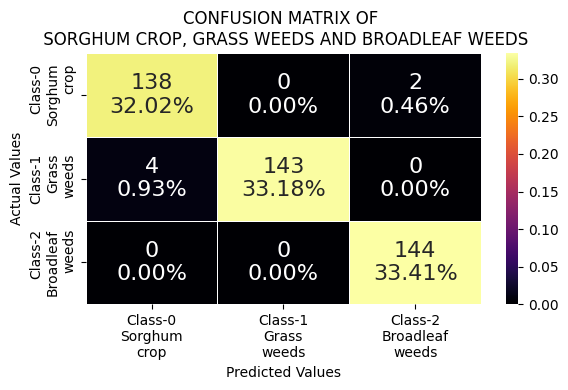

<Figure size 640x480 with 0 Axes>

In [8]:
# Model Evaluation
print("\n-------------- Model Evaluation-------------\n")
evaluate_test_data = model.evaluate(test_set)
test_loss = evaluate_test_data[0]
test_acc = evaluate_test_data[1]
print("HierbaNetV1 Testing accuracy: ", test_acc)
print("HierbaNetV1 Testing loss: ", test_loss)

#Ground truth of test set
y_test= test_set.classes

#Predicting the test set
y_pred = []
predict_result = model.predict(test_set)
for index, prediction in enumerate(predict_result):
    classes = np.argmax(prediction)
    y_pred.append([classes])

#Classification report
print("\n-------------- Classification report-------------\n")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# HEAT MAP for confusion matrix
cm_type = confusion_matrix(y_test, y_pred)
group_counts = ['{0:0.0f}'.format(value) for value in cm_type.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm_type.flatten()/np.sum(cm_type)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)] # use this label to display both count and percentage
labels = np.asarray(labels).reshape(num_classes,num_classes)
figure = plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_type/np.sum(cm_type), annot=labels, fmt='', cmap='inferno', annot_kws={"size": 16}, linecolor='white', linewidths=0.7)
ax.set_title('CONFUSION MATRIX OF \n SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
ax.yaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
plt.tight_layout()
plt.show()
plt.clf()